# ResNet & ResNext Transfer Learning on Eurosat Dataset

## 1. Environment Setup

### 1.1 Colab Environment

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
## Appending path of GDrive folder to system path to access private modules and files
import sys
sys.path.append('/content/drive/MyDrive/ml-mavericks')

In [61]:
!pip install rasterio

### 1.2 Imports

In [62]:
### Torch modules
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.optim as optim

### Rasterio modules
import rasterio
from rasterio.plot import reshape_as_image

### Other DS modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Other modules
from tqdm import tqdm
from datetime import datetime
import os 
import time
import copy
import h5py

## Private modules
from utils.utils import EurosatPreloadedDataset, EurosatPreloadedTestset, plot_confusion_matrix, plot_learning_curve

### 1.2 Global Variables

The path variables may need to be adjusted depending on your system.

In [63]:
## Path to load training and test data (in .H5 format)
TRAINING_PATH = "/content/drive/MyDrive/ml-mavericks/data/trainingset_RGB_NDVI.h5"
TEST_PATH = "/content/drive/MyDrive/ml-mavericks/data/testset_RGB_NDVI.h5"

# Path to save models, visualizations, and submisssion
MODEL_PATH = "/content/drive/MyDrive/ml-mavericks/models"
VISUALIZATION_PATH = "/content/drive/MyDrive/ml-mavericks/visualisation"
SUBMISSION_PATH = "/content/drive/MyDrive/ml-mavericks/submissions"

In [64]:
## Initialization of CLASS_LABELS: list of the 10 land cover types covered in Eurosat 
CLASS_LABELS = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", 
                "Permanent Crop", "Residential", "River", "SeaLake"]

## Initialization of ID2LABEL: dictionary that maps numerical IDs to their corresponding land cover types
ID2LABEL = {0: "AnnualCrop", 1: "Forest", 2: "HerbaceousVegetation", 3: "Highway", 4: "Industrial", 
            5: "Pasture", 6: "PermanentCrop", 7: "Residential", 8: "River", 9: "SeaLake"}

In [65]:
## Initialization of Torch device to use CUDA for GPU acceleration for faster computation
DEVICE = torch.device("cuda") 

## 2. Data Setup

### 2.1 Train-Validation Split

As we use different data augmentations for the training and validation set, we have to split our data before loading it. This will enable us to have two different class instances that load the specific indices for train resp. validation data.

In [66]:
## Setting the train-validation split ratio to 0.12
TRAIN_VAL_SPLIT_RATIO = 0.12

In [67]:
## Creating a list of indices of the training data for train-validation split
with h5py.File(TRAINING_PATH, "r") as f:
    X = list(f['labels'])
    X_indices = [i for i in range(len(X))]

In [68]:
## Splitting indices into training and validation indices using train_test_split function
## Result indices are used to extract to the corresponding data from the dataset later on
X_train_indices, X_val_indices = train_test_split(X_indices, shuffle=True, random_state=42, test_size=TRAIN_VAL_SPLIT_RATIO)

In [69]:
## Creating dictionary with the sizes of the training and validation datasets, respectively
dataset_sizes = {"train": len(X_train_indices), "val": len(X_val_indices)}

In [70]:
## Code to sort the indices of training and validation data (otherwise, it does not run)
X_train_indices.sort()
X_val_indices.sort()

### 2.2 Data Augmentations

In [71]:
## Setting image transformations for training, validation, and testing 
## Transformations include resizing, rotating, flipping, center cropping

transform_train = transforms.Compose([

        # transform from array to tensor
        transforms.ToTensor(),

        # enlarge the images by bilinear interpolation
        transforms.Resize([92,92], antialias=None),                            

        # rotate the picture by the degree input
        transforms.RandomRotation(5),

        # pad the edges by 10 pixels
        transforms.RandomCrop(112, padding = 10),

        # normalize with mean and standard deviation for each channel
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_val = transforms.Compose([

        # transform from array to tensor
        transforms.ToTensor(),

        # enlarge the images by bilinear interpolation
        transforms.Resize([92,92], antialias=None),
        
        # cut the image from the center
        transforms.CenterCrop(112),

        # normalize with mean and standard deviation for each channel
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  

transform_test = transforms.Compose([

        # transform from array to tensor
        transforms.ToTensor(),

        # enlarge the images by bilinear interpolation
        transforms.Resize([92,92], antialias=None),
        
        # cut the image from the center
        transforms.CenterCrop(112),

        # normalize with mean and standard deviation for each channel
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  

### 2.3 Data Loading

We create a dataloader with our custom data sets to iterate through its samples.
Validation and Training set share the same data set class, but load different images (through the indices given).

In [72]:
BATCH_SIZE = 32

In [73]:
trainset = EurosatPreloadedDataset(root_dir=TRAINING_PATH, transform=transform_train, classes=CLASS_LABELS, indices=X_train_indices)
valset = EurosatPreloadedDataset(root_dir=TRAINING_PATH, transform=transform_val, classes=CLASS_LABELS, indices=X_val_indices)

In [74]:
testset = EurosatPreloadedTestset(root_dir=TEST_PATH, transform=transform_test)

In [75]:
## Loading data into DataLoader
training_dl = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dl = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## 3. Model Setup

### 3.1 Model initialization

There are two pretrained models that you may choose from: ResNet50 or ResneXt101_64x4d.

In [ ]:
## Download resnet50 or resnext101_64x4d 
# pretrained_model = models.resnext101_64x4d(pretrained=True) 
model_ft = models.resnet50(pretrained=True)

## Freeze all layers except the final layer - didnt show better performance (needs additional layers)
## for param in model_ft.parameters():
##    param.requires_grad = False

## Adjusting model to fit for number of categories
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(CLASS_LABELS))

In [ ]:
## Introduce a dropout layer - didnt show better performance
class PretrainedWithDropout(nn.Module):
    def __init__(self, pretrained_model, dropout_prob):
        super(PretrainedWithDropout, self).__init__()
        self.pretrained_model = pretrained_model
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.dropout(x)
        return x

## Define the dropout probability
dropout_prob = 0.2

#model_ft = PretrainedWithDropout(pretrained_model, dropout_prob)

In case you would like to continue from a checkpoint, you may uncomment the following cell:

In [ ]:
# checkpoint = torch.load('/content/drive/MyDrive/ml-mavericks/models/resnext_20230520_095514_epochs5_dropout02.pth')  # load the saved state dictionary
# model_ft.load_state_dict(checkpoint)  # assign the state dictionary to the model

In [77]:
## Putting to device for 
model_ft = model_ft.to(DEVICE) # no dropout in this case

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 4. Training & Evaluation

During training we track the train and validation accuracy: We store the model with best validation accuracy over all epochs.

### 4.1 Model Training

In [78]:
formatted_now = datetime.now().strftime("%Y%m%d_%H%M%S")

In [79]:
## Setting function for model training
train_losses = []
val_losses = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            
            if phase == 'train':
                dataloaders = training_dl
            else: 
                dataloaders = val_dl

            for inputs, labels in tqdm(dataloaders):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
              train_losses.append(epoch_loss)
            else:
              val_losses.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Saving each epoch
        torch.save(model.state_dict(), os.path.join(MODEL_PATH, f'resnext_{formatted_now}_epochs{epoch +1}.pth'))   

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

 Let's define the number of epochs:

In [82]:
EPOCHS = 3

And start the trainging:

In [ ]:
## Running time roughly 45 sec per epoch (with A100 GPU & 2 workers)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 1/3
----------


100%|██████████| 743/743 [00:32<00:00, 22.71it/s]


train Loss: 0.9593 Acc: 0.7619


100%|██████████| 102/102 [00:03<00:00, 31.44it/s]


val Loss: 0.3337 Acc: 0.9157

Epoch 2/3
----------


100%|██████████| 743/743 [00:32<00:00, 23.00it/s]


train Loss: 0.3191 Acc: 0.9059


100%|██████████| 102/102 [00:03<00:00, 32.20it/s]


val Loss: 0.1958 Acc: 0.9460

Epoch 3/3
----------


100%|██████████| 743/743 [00:32<00:00, 22.94it/s]


train Loss: 0.2266 Acc: 0.9300


100%|██████████| 102/102 [00:03<00:00, 31.82it/s]


val Loss: 0.1590 Acc: 0.9540

Training complete in 1m 48s
Best val Acc: 0.954012


### 4.2 Visualizations

100%|██████████| 3240/3240 [00:28<00:00, 115.62it/s]


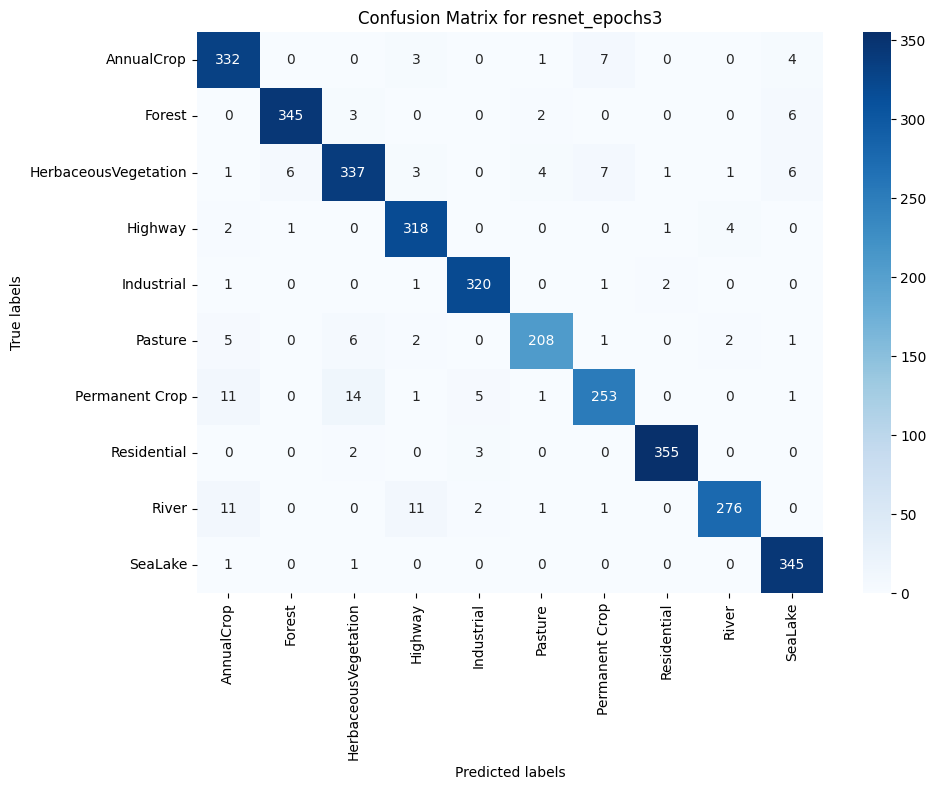

In [ ]:
## Plots a confusion matrix to show the misclassification for all classes
plot_confusion_matrix(model_ft, valset, CLASS_LABELS, f"resnet_epochs{EPOCHS}", os.path.join(VISUALIZATION_PATH, f'confusion_matrix_resnext101_{formatted_now}_epochs{EPOCHS}.jpg'), DEVICE)

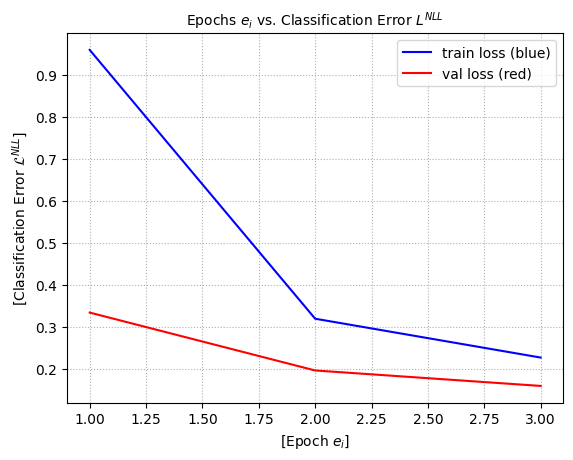

In [ ]:
## Plots the training and validation loss over time
plot_learning_curve(train_losses, val_losses, f"resnet50_epochs{EPOCHS}", formatted_now, VISUALIZATION_PATH)

### 4.3 Saving Model

In [ ]:
## Saving the model
torch.save(model_ft.state_dict(), os.path.join(MODEL_PATH, f'resnet50_epochs{EPOCHS}_{formatted_now}.pth'))

## 5. Inference

### 5.1 Inference on Test Data

In [ ]:
predicted_results = []

for i in tqdm(range(len(testset.ids))):
    model = model_ft.eval()
    sample, id = testset.__getitem__(i)
    sample = sample.to(DEVICE)
    
    with torch.no_grad():
        output = model(sample.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
    
    predicted_group = ID2LABEL[predicted.item()]
    testid = int(id)
    
    predicted_results.append((testid, predicted_group))

100%|██████████| 4232/4232 [00:38<00:00, 109.97it/s]


### 5.2 Submission File

In [ ]:
submission = pd.DataFrame(predicted_results, columns=["test_id", "label"])
submission = submission.sort_values("test_id")
submission.to_csv(os.path.join(SUBMISSION_PATH, f"submission_resnet50_epochs{EPOCHS}_{formatted_now}.csv"), index=False)